In [ ]:
#!pip install nltk
#!pip install re

In [38]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras_tuner as kt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

## Brief description of the problem and data (5 pts)
### 
Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

We must identify whether tweets with "disaster" words are appropriately disasters given contextual information. The data consists of 7613 training tweets all hand labelled, with features keyword, location, text along with 3263 test tweets

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

### Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

I first will clean the text with the help of nltk and regex. I am removing links, special characters, etc. to make the data tokenizable. Once it is tokenizable, i will use a tokenizer and then vectorize and pad the sequences. After that it should be ready to go.

In [24]:
train_df = pd.read_csv('./train.csv')
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text)
    words = word_tokenize(text)
    return [word for word in words if word not in stop_words]

train_df['preprocessed_text'] = train_df['text'].apply(preprocess_text)

print(train_df[['text', 'preprocessed_text']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cameron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cameron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                   preprocessed_text  
0  [deeds, reason, earthquake, may, allah, forgiv...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [residents, asked, shelter, place, notified, o...  
3  [13000, people, receive, wildfires, evacuation...  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...  


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['preprocessed_text'].apply(lambda x: ' '.join(x)))

sequences = tokenizer.texts_to_sequences(train_df['preprocessed_text'].apply(lambda x: ' '.join(x)))

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 18011 unique tokens.


In [5]:
max_length = max(len(x) for x in sequences)
print(len(word_index))
padded_sequences = pad_sequences(sequences, maxlen=max_length)

18011


In [6]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, train_df['target'], test_size=0.2, random_state=0)
print(X_train.shape)

(6090, 25)


## Model Architecture (25 pts)

#### Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

#### Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

#### There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

#### Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

We learned about RNN's and I am interested to see how LSTM's work, regardless of whether they are the best in this case so i will be using that. I used Keras's Documentation to learn how to implement LSTM's

In [31]:
# Model parameters
vocab_size = len(word_index) + 1
embed_size = 300

model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=max_length))
model.add(LSTM(2, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 25, 300)           5403600   
                                                                 
 lstm_9 (LSTM)               (None, 2)                 2424      
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 5406027 (20.62 MB)
Trainable params: 5406027 (20.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
191/191 [==============================] - 9s 35ms/step - loss: 0.6141 - accuracy: 0.7071 - val_loss: 0.5257 - val_accuracy: 0.7833
Epoch 2/20
191/191 [==============================] - 6s 34ms/step - loss: 0.3937 - accuracy: 0.8686 - val_loss: 0.4719 - val_accuracy: 0.7905
Epoch 3/20
191/191 [==============================] - 6s 34ms/step - loss: 0.2324 - accuracy: 0.9337 - val_loss: 0.5006 - val_accuracy: 0.7781
Epoch 4/20
191/191 [==============================] - 6s 34ms/step - loss: 0.1502 - accuracy: 0.9593 - val_loss: 0.5350 - val_accuracy: 0.7814
Epoch 5/20
191/191 [==============================] - 7s 34ms/step - loss: 0.1071 - accuracy: 0.9709 - val_loss: 0.5788 - val_accuracy: 0.7708
Epoch 6/20
191/191 [==============================] - 6s 34ms/step - loss: 0.0836 - accuracy: 0.9780 - val_loss: 0.6140 - val_accuracy: 0.7781
Epoch 7/20
191/191 [==============================] - 7s 34ms/step - loss: 0.0715 - accuracy: 0.9791 - val_loss: 0.6496 - val_accuracy: 0.7656

In [30]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

48/48 [==============================] - 0s 2ms/step - loss: 0.7897 - accuracy: 0.7735
Validation Loss: 0.7896914482116699
Validation Accuracy: 0.7734733819961548


In [ ]:
print(tf.__version__)


Training Notes:
- Model is too complex at 1 layer 128 neurons

## Results and Analysis (35 pts)

#### Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

#### Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [ ]:
Because the model is quick to train i want to run a small learning rate and many epochs to help convergence

In [45]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0004,
    patience=10,
    restore_best_weights=True,
    mode='min'
)

In [39]:
def tuning_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=hp.Int('embed_size', min_value = 10, max_value = 1010, step=500),
                        input_length=max_length))
    model.add(LSTM(units=hp.Int('units', min_value=4, max_value=16, step=4), 
                   dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0001, 0.0005])), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [40]:
tuner = kt.RandomSearch(tuning_model,
                        objective='val_accuracy',
                        max_trials=50,
                        executions_per_trial=1,
                        directory='./tuning_results',
                        project_name='lstm_random_search')

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')},
and the optimal dropout rate is {best_hps.get('dropout')}.
""")

Trial 50 Complete [00h 03m 27s]
val_accuracy: 0.7990807890892029

Best val_accuracy So Far: 0.8063033223152161
Total elapsed time: 01h 33m 35s

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 16,
and the optimal dropout rate is 0.4.



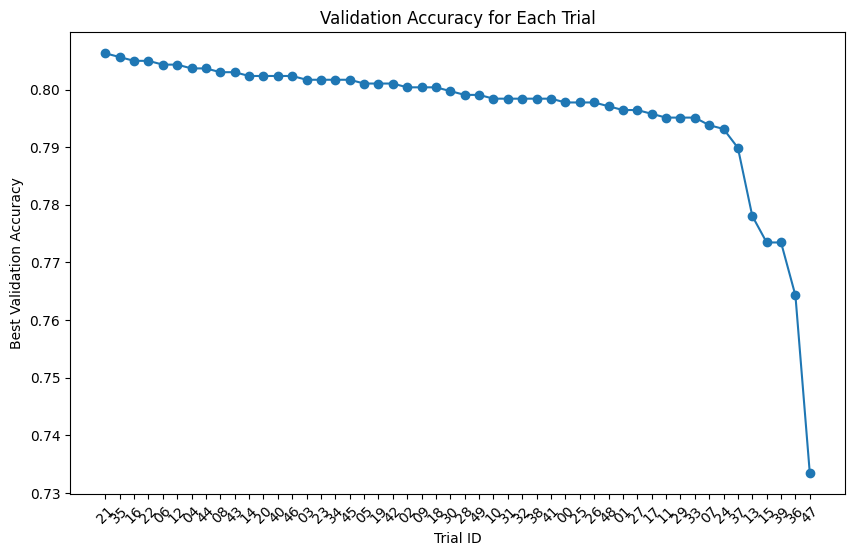

In [42]:
trials = tuner.oracle.get_best_trials(num_trials=tuner.oracle.max_trials)

trial_ids = [trial.trial_id for trial in trials]
val_accuracies = [trial.metrics.get_best_value('val_accuracy') for trial in trials]

plt.figure(figsize=(10, 6))
plt.plot(trial_ids, val_accuracies, marker='o')
plt.title('Validation Accuracy for Each Trial')
plt.xlabel('Trial ID')
plt.ylabel('Best Validation Accuracy')
plt.xticks(rotation=45)
plt.show()

A very small neural network was good for this project to reduce overfitting. Unfortunately the model itself does not perform the best

In [46]:
tuned_model = tuning_model(best_hps)
tuned_model_history = tuned_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=150,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[early_stopping]
)

tuned_model_val_loss, tuned_model_val_accuracy = tuned_model.evaluate(X_val, y_val)
print(f'Validation Loss: {tuned_model_val_loss}')
print(f'Validation Accuracy: {tuned_model_val_accuracy}')

Epoch 1/150
191/191 [==============================] - 3s 8ms/step - loss: 0.6773 - accuracy: 0.5675 - val_loss: 0.6565 - val_accuracy: 0.5817
Epoch 2/150
191/191 [==============================] - 1s 6ms/step - loss: 0.5850 - accuracy: 0.7056 - val_loss: 0.5348 - val_accuracy: 0.7643
Epoch 3/150
191/191 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.8358 - val_loss: 0.4836 - val_accuracy: 0.7873
Epoch 4/150
191/191 [==============================] - 1s 5ms/step - loss: 0.3119 - accuracy: 0.8777 - val_loss: 0.4712 - val_accuracy: 0.7886
Epoch 5/150
191/191 [==============================] - 1s 5ms/step - loss: 0.2421 - accuracy: 0.9095 - val_loss: 0.5012 - val_accuracy: 0.7682
Epoch 6/150
191/191 [==============================] - 1s 5ms/step - loss: 0.1986 - accuracy: 0.9281 - val_loss: 0.5147 - val_accuracy: 0.7866
Epoch 7/150
191/191 [==============================] - 1s 5ms/step - loss: 0.1603 - accuracy: 0.9427 - val_loss: 0.5486 - val_accuracy: 0.7787

In [53]:
#test data
test_df = pd.read_csv('./test.csv')

test_df['preprocessed_text'] = test_df['text'].apply(preprocess_text)

test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(test_df['preprocessed_text'].apply(lambda x: ' '.join(x)))

test_sequences = test_tokenizer.texts_to_sequences(test_df['preprocessed_text'].apply(lambda x: ' '.join(x)))

test_word_index = test_tokenizer.word_index
print(f"Found {len(test_word_index)} unique tokens.")

test_max_length = max(len(x) for x in test_sequences)
print(len(test_word_index))
test_padded_sequences = pad_sequences(test_sequences, maxlen=test_max_length+2) #max length is 23 but i need 25 for model

label_pred = tuned_model.predict(test_padded_sequences)

test_predictions = pd.DataFrame({
    'id': test_df['id'],
    'target': np.around(label_pred.flatten())
})

test_predictions.to_csv('./submission_final.csv', index=False)

Found 10606 unique tokens.
10606
102/102 [==============================] - 0s 1ms/step


In [ ]:
tuned_model_val_loss, tuned_model_val_accuracy = tuned_model.evaluate(X_val, y_val)
print(f'Validation Loss: {tuned_model_val_loss}')
print(f'Validation Accuracy: {tuned_model_val_accuracy}')

## Conclusion (15 pts)
#### 
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Not much actually improved the performance of my model, and it was hard to avoid overfitting. In the future i'd like to try doing some data augmentation to paraphrase and replace words to increase vocabulary. I think this will add complexity and be able to generalize to the test data better.

## Reference's:

- https://www.nltk.org/api/nltk.html
- https://keras.io/api/